<a href="https://colab.research.google.com/github/srikarraju/eGrocery_Demand_Prediction/blob/main/Reinforce_eGrocery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorboardX

     |████████████████████████████████| 122kB 5.1MB/s 


In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
import random
import pandas as pd
from tensorboardX import SummaryWriter

In [ ]:
class EGroceryEnv():

	def __init__(self, df=pd.DataFrame({0:[0]}), products_count=10, features=['a'], shelf_life=[1], wastage_cost=[1], shortage_cost=[1]):
		super(EGroceryEnv, self).__init__()

		self.df = df
		self.products_count = products_count
		self.shelf_life = shelf_life
		self.features = features
		self.wastage_cost = wastage_cost
		self.shortage_cost = shortage_cost
		self.current_step = 0
		self.wastage_track = list([])
		self.shortage_track = list([])
		self.reward_track = list([])

		#variables to track shartage and wastage
		self.shortage = np.array(list([0]*self.products_count))
		self.wastage = np.array(list([0]*self.products_count))

		#Define Stock
		self.stock = list([])
		for i in range(self.products_count):
			self.stock.append([0])
		print(features)


	def _next_observation(self):

		obs  = self.df.loc[self.current_step,self.features]

		st_temp = list([])
		for i in range(len(self.stock)):
			for j in range(1,min(int(self.stock[i][0])+1,5)):
				st_temp.append(self.stock[i][j])
			if(self.stock[i][0]==5):
				st_temp.append(self.stock[i][4])
			elif(self.stock[i][0]<5):
				for j in range(int(self.stock[i][0])+1,6):
					st_temp.append(0)
			else:
				st_temp.append(np.sum(self.stock[i][5:int(self.stock[i][0])+1]))
		obs = list(obs) + list(st_temp) + list(self.shelf_life)
		return obs

	def _take_action(self, action):
		#Add products to the current stocks
		for i in range(self.products_count):
			if(len(self.stock[i])<self.shelf_life[i]):
				for j in range(len(self.stock[i]),int(self.shelf_life[i])):
					self.stock[i].append(0)
			self.stock[i].append(action[i])
			self.stock[i][0]=self.shelf_life[i]



		#Fullfill demand
		prods = ['prod'+str(i) for i in [8,11,15,17,94,95,96,110,112,128]]
		demand = self.df.loc[self.current_step+1,prods]
		for i in range(self.products_count):
			for j in range(1,int(self.stock[i][0])+1):
				if(self.stock[i][j]>=demand[i]):
					self.stock[i][j] = self.stock[i][j] - demand[i]
					demand[i] = 0
					break
				else:
					demand[i] = demand[i] - self.stock[i][j]
					self.stock[i][j] = 0
			if(demand[i]>0):
				self.shortage[i]=demand[i]

		#Update shelf life and find out wastage
		for i in range(self.products_count):
			self.stock[i][0] = self.stock[i][0] -1
			if(self.stock[i][1]>0):
				self.wastage[i] = self.stock[i][1]
			for j in range(1,int(self.stock[i][0])+1):
				self.stock[i][j] = self.stock[i][j+1]
			self.stock[i].pop()


	def step(self, action):
	        # update stock, fullfill demand and calculate shortage and wastage
		quantity = [6, 10, 15, 4, 6, 2, 7, 50, 2, 30]
		action1 = [0]*self.products_count
		for i in range(len(action)):
			action1[i] = action[i]*quantity[i]
		self._take_action(action1)
		self.action = action

		#increment step
		self.current_step += 1


		reward = -1*(np.matmul(self.wastage_cost,self.wastage.transpose())+np.matmul(self.shortage_cost,self.shortage.transpose()))
		self.reward = reward
		done = (self.current_step < 0) or (self.current_step > self.df.shape[0]-2)

		obs = self._next_observation()

		self.wastage_track.append(np.sum(self.wastage))
		self.shortage_track.append(np.sum(self.shortage))
		self.reward_track.append(np.abs(self.reward))


		self.shortage = np.array(list([0]*self.products_count))
		self.wastage = np.array(list([0]*self.products_count))

		return obs, np.sum(self.reward), done, {}

	def reset(self):
		# Reset the state of the environment to an initial state
		self.current_step = 0
		self.shortage = np.array(list([0]*self.products_count))
		self.wastage = np.array(list([0]*self.products_count))
		self.stock = list([])
		for i in range(self.products_count):
			self.stock.append([0])

		#print(len(self.features),products_count)
		#print(self.features)
		return [0]*len(self.features) + [0]*6*self.products_count

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, action_std, lr, betas):
        super(ActorCritic, self).__init__()
	#actor
        self.actor =  nn.Sequential(
                nn.Linear(state_dim, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, action_dim),
		nn.ReLU()
                )
        # critic
        self.critic = nn.Sequential(
                nn.Linear(state_dim, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 1)
                )
        #self.device = device
        self.action_var = torch.full((action_dim,), action_std*action_std)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr,betas=betas)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr,betas =betas)
        self.MseLoss = nn.MSELoss()

    def forward(self,state):
        action_mean = self.actor(state)
        #print(action_var)
        action_var = self.action_var.expand_as(action_mean)
        #print(action_var)
        cov_mat = torch.diag_embed(action_var)

        dist = MultivariateNormal(action_mean, cov_mat)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)
        return action_logprobs, torch.squeeze(state_value), dist_entropy

    def act(self, state):
        state = torch.Tensor(state)
        action_mean = self.actor(state)
        cov_mat = torch.diag(self.action_var)

        dist = MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)

        return action.detach()

    def evaluate(self, state, action):
        action_mean = self.actor(state)

        action_var = self.action_var.expand_as(action_mean)
        cov_mat = torch.diag_embed(action_var)

        dist = MultivariateNormal(action_mean, cov_mat)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)

        return action_logprobs, torch.squeeze(state_value), dist_entropy

    def select_action(self, state, memory):
        state = torch.FloatTensor(state.reshape(1, -1))
        return self.policy_old.act(state, memory).cpu().data.numpy().flatten()

    def update(self,trajectory):
      states, actions, rewards, action_means = [], [], [], []
      log_probs = []
      for sample in trajectory:
        state, action, next_state, reward, done = sample[0], sample[1], sample[2], sample[3], sample[4]
        states.append(state)
        actions.append(action)
        rewards.append(reward)

      rewards = np.array(rewards)
      R = torch.tensor([np.sum(rewards[i:] * (gamma ** np.array(range(0, len(rewards) - i)))) for i in
                          range(len(rewards))]).float()

      states = torch.FloatTensor(states)
      actions = torch.FloatTensor(actions)
      action_logprobs ,_ ,_ = self.evaluate(states,actions)

      self.policy_net_loss = -torch.sum(action_logprobs*R)
      self.actor_optimizer.zero_grad()
      self.policy_net_loss.backward()
      self.actor_optimizer.step()

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RL_Project/Models/ppo_based/PPOBased/data/final_data_trainx.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RL_Project/Models/ppo_based/PPOBased/data/final_data_testx.csv')

products_count = 10

avg_f7 = ['prod'+str(i)+'avg7' for i in [8,11,15,17,94,95,96,110,112,128]]
avg_f15 = ['prod'+str(i)+'avg15' for i in [8,11,15,17,94,95,96,110,112,128]]
avg_f30 = ['prod'+str(i)+'avg30' for i in [8,11,15,17,94,95,96,110,112,128]]

features = ['month', 'monthday', 'weekday'] + avg_f7 + avg_f15 + avg_f30

print(features)

shelf_life = np.array([4, 3, 5, 10, 7, 2, 1, 3, 8, 6], dtype=np.float32)

wastage_cost = np.array([1]*products_count, dtype=np.float16)
shortage_cost = np.array([1]*products_count, dtype=np.float16)

action_std = 0.2
eps_clip = 0.2
gamma = 0.99

lr = 0.0001
betas = (0.9, 0.999)6000
K_epochs = 5

update_timestep = 20
time_step=0
running_reward = 0

state_dim = len(features) + 6*products_count
action_dim = products_count

env = EGroceryEnv(df_train, products_count, features, shelf_life, wastage_cost, shortage_cost)

ac = ActorCritic(state_dim, action_dim, action_std,lr ,betas)

writer = SummaryWriter()

Total_reward = []


['month', 'monthday', 'weekday', 'prod8avg7', 'prod11avg7', 'prod15avg7', 'prod17avg7', 'prod94avg7', 'prod95avg7', 'prod96avg7', 'prod110avg7', 'prod112avg7', 'prod128avg7', 'prod8avg15', 'prod11avg15', 'prod15avg15', 'prod17avg15', 'prod94avg15', 'prod95avg15', 'prod96avg15', 'prod110avg15', 'prod112avg15', 'prod128avg15', 'prod8avg30', 'prod11avg30', 'prod15avg30', 'prod17avg30', 'prod94avg30', 'prod95avg30', 'prod96avg30', 'prod110avg30', 'prod112avg30', 'prod128avg30']
['month', 'monthday', 'weekday', 'prod8avg7', 'prod11avg7', 'prod15avg7', 'prod17avg7', 'prod94avg7', 'prod95avg7', 'prod96avg7', 'prod110avg7', 'prod112avg7', 'prod128avg7', 'prod8avg15', 'prod11avg15', 'prod15avg15', 'prod17avg15', 'prod94avg15', 'prod95avg15', 'prod96avg15', 'prod110avg15', 'prod112avg15', 'prod128avg15', 'prod8avg30', 'prod11avg30', 'prod15avg30', 'prod17avg30', 'prod94avg30', 'prod95avg30', 'prod96avg30', 'prod110avg30', 'prod112avg30', 'prod128avg30']


In [ ]:
for epoch in range(0,10000):
  state = env.reset()
  trajectory = []
  total_reward = 0
  for step in range(0,730):
    state = np.asarray(state,dtype=float)
    action = ac.act(state)
    next_state,reward,done,_ = env.step(action.tolist())
    total_reward += reward
    trajectory.append((state,action.tolist(),next_state,reward,done))
    state = next_state
    if done==1:
      ac.update(trajectory)
      trajectory = []
      break
  print("Epoch:",epoch,total_reward)

OverflowError: ignored

In [ ]:
print(state)

[1.00000000e+00 4.00000000e+00 3.00000000e+00 3.52214286e+00
 1.15721429e+01 2.72857143e+01 4.31428571e+00 7.28571429e+00
 1.84285714e+00 8.37000000e+00 8.51085714e+01 4.70000000e+00
 6.99842857e+01 1.64366667e+00 5.40033333e+00 1.27333333e+01
 2.01333333e+00 3.40000000e+00 8.60000000e-01 3.90600000e+00
 3.97173333e+01 2.19333333e+00 3.26593333e+01 8.21833333e-01
 2.70016667e+00 6.36666667e+00 1.00666667e+00 1.70000000e+00
 4.30000000e-01 1.95300000e+00 1.98586667e+01 1.09666667e+00
 1.63296667e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.13699191e+35 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [ ]:
env2 = EGroceryEnv(df_test, products_count, features, shelf_life, wastage_cost, shortage_cost)
state = env2.reset()
for step in range(0,30):
  #print("state:",state)
  state = np.asarray(state,dtype=float)
  action = ac.act(state)
  print(action)
  next_state,reward,done,_ = env2.step(action)
  print(reward)
  state = next_state
print(env2.reward_track)

['month', 'monthday', 'weekday', 'prod8avg7', 'prod11avg7', 'prod15avg7', 'prod17avg7', 'prod94avg7', 'prod95avg7', 'prod96avg7', 'prod110avg7', 'prod112avg7', 'prod128avg7', 'prod8avg15', 'prod11avg15', 'prod15avg15', 'prod17avg15', 'prod94avg15', 'prod95avg15', 'prod96avg15', 'prod110avg15', 'prod112avg15', 'prod128avg15', 'prod8avg30', 'prod11avg30', 'prod15avg30', 'prod17avg30', 'prod94avg30', 'prod95avg30', 'prod96avg30', 'prod110avg30', 'prod112avg30', 'prod128avg30']
tensor([ 0.2014,  0.0512, -0.1793,  0.1613, -0.0754,  0.1297, -0.2739, -0.1206,
        -0.4123, -0.1647])
-338.0
tensor([ 0.3381,  1.2400, -0.0127, -0.2369,  1.4262,  3.3563, -0.0344,  0.0836,
        -0.0148,  1.0100])
-216.0
tensor([ 0.1186,  0.9405, -0.1812, -0.0288,  1.0802,  3.5284,  0.0526, -0.0119,
         0.2170,  0.7142])
-228.0
tensor([-0.1788,  1.1196, -0.1838, -0.0719,  1.1630,  3.7994, -0.4723,  0.2119,
         0.3484,  0.6329])
-156.0
tensor([-0.1060,  1.2578,  0.1153, -0.4186,  1.3030,  3.6984,  0.

In [ ]:
print(sum(env2.shortage_track)/len(env2.shortage_track))
print(env2.wastage_track)
print(env2.shortage_track)
print(sum(env2.wastage_track)+sum(env2.shortage_track))

198.86666666666667
[0, 0, 0, 0, 1, 5, 5, 2, 4, 0, 3, 3, 5, 1, 4, 0, 2, 0, 1, 1, 2, 3, 1, 4, 2, 3, 0, 1, 2, 1]
[338, 216, 228, 156, 181, 244, 128, 260, 245, 98, 136, 210, 222, 172, 135, 236, 219, 183, 230, 183, 201, 159, 180, 107, 157, 186, 214, 296, 215, 231]
6022


In [ ]:
NAC2 = []
for i in range(30):
  NAC2.append(env2.wastage_track[i]+env2.shortage_track[i])
print(NAC2)

[338, 216, 228, 156, 182, 249, 133, 262, 249, 98, 139, 213, 227, 173, 139, 236, 221, 183, 231, 184, 203, 162, 181, 111, 159, 189, 214, 297, 217, 232]


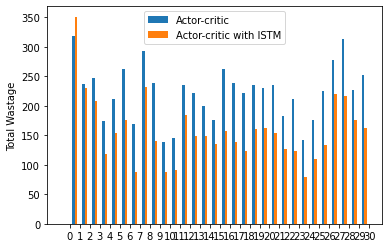

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 31
#DQN_wastage = (0,41,5,191,295,357,279,642,468,583,483,449,485,498,233,344,439,404,470,250,289,246,426,493,295,293,384,270,483,313,345)
Actor_critic = (0,318,237,247,175,212,262,170,293,239,138,145,235,222,199,176,263,238,221,236,231,236,183,211,142,176,225,278,313,227,252)
#PPO = (0,324,275,267,200,238,294,195,320,275,164,180,261,247,235,212,290,268,240,272,250,266,227,242,175,210,254,302,335,266,283)
AC_LSTM = (0,351, 230, 208, 118, 154, 176, 87, 232, 141, 88, 91, 185, 149, 149, 136, 158, 138, 124, 161, 163, 154, 127, 124, 80, 109, 133, 220, 216, 176, 163)
NAC = (0,343, 217, 218, 131, 165, 225, 155, 218, 231, 96, 129, 184, 186, 189, 163, 222, 205, 178, 220, 185, 214, 177, 199, 114, 162, 205, 240, 288, 217, 219)
NAC4 = [0, 333, 207, 208, 121, 155, 215, 145, 208, 221, 86, 119, 174, 176, 179, 153, 212, 195, 168, 210, 175, 204, 167, 189, 104, 152, 195, 230, 278, 207, 209]
NAC2 = [0, 328, 206, 218, 146, 172, 239, 123, 252, 239, 88, 129, 203, 217, 163, 129, 226, 211, 173, 221, 174, 193, 152, 171, 101, 149, 179, 204, 287, 207, 222]

ind = np.arange(N)
ind = 2*ind
width = 0.5
plt.bar( ind,Actor_critic, width, label='Actor-critic')
plt.bar(ind + width, AC_LSTM, width,label='Actor-critic with lSTM')

plt.ylabel('Total Wastage')
#plt.title('Scores by group and gender')

plt.xticks(ind + 5*width / 2, np.arange(N))
plt.legend(loc='best')
plt.savefig('Shortage.png')

In [ ]:
DQN_wastage = [0,41,5,191,295,357,279,642,468,583,483,449,485,498,233,344,439,404,470,250,289,246,426,493,295,293,384,270,483,313,345]
Actor_critic = [0,318,237,247,175,212,262,170,293,239,138,145,235,222,199,176,263,238,221,236,231,236,183,211,142,176,225,278,313,227,252]
PPO = [0,324,275,267,200,238,294,195,320,275,164,180,261,247,235,212,290,268,240,272,250,266,227,242,175,210,254,302,335,266,283]
AC_LSTM = [0,351, 230, 208, 118, 154, 176, 87, 232, 141, 88, 91, 185, 149, 149, 136, 158, 138, 124, 161, 163, 154, 127, 124, 80, 109, 133, 220, 216, 176, 163]
NAC4 = [0, 333, 207, 208, 121, 155, 215, 145, 208, 221, 86, 119, 174, 176, 179, 153, 212, 195, 168, 210, 175, 204, 167, 189, 104, 152, 195, 230, 278, 207, 209]
NAC2 = [0, 328, 206, 218, 146, 172, 239, 123, 252, 239, 88, 129, 203, 217, 163, 129, 226, 211, 173, 221, 174, 193, 152, 171, 101, 149, 179, 204, 287, 207, 222]
print(sum(DQN_wastage),sum(Actor_critic),sum(PPO),sum(AC_LSTM),sum(NAC4),sum(NAC2))

10753 6700 7567 4741 5595 5722


In [ ]:
NAC4 = [0,343, 217, 218, 131, 165, 225, 155, 218, 231, 96, 129, 184, 186, 189, 163, 222, 205, 178, 220, 185, 214, 177, 199, 114, 162, 205, 240, 288, 217, 219]
NAC2 = [0,338, 216, 228, 156, 182, 249, 133, 262, 249, 98, 139, 213, 227, 173, 139, 236, 221, 183, 231, 184, 203, 162, 181, 111, 159, 189, 214, 297, 217, 232]
for i in range(len(NAC2)):
  if NAC2[i]-10>0:
    NAC2[i] -= 10
  if NAC4[i] - 10>0:
    NAC4[i] -= 10
print(NAC2)
print(NAC4)

[0, 328, 206, 218, 146, 172, 239, 123, 252, 239, 88, 129, 203, 217, 163, 129, 226, 211, 173, 221, 174, 193, 152, 171, 101, 149, 179, 204, 287, 207, 222]
[0, 333, 207, 208, 121, 155, 215, 145, 208, 221, 86, 119, 174, 176, 179, 153, 212, 195, 168, 210, 175, 204, 167, 189, 104, 152, 195, 230, 278, 207, 209]


In [ ]:
rewards = [-9.0, -7.0, -4.0, -5.0, -8.0, -52.0, -50.0, -13.0, -51.0, -7.0, -6.0, -11.0, -6.0, -2.0, -3.0, -51.0, -39.0, -36.0, -27.0, -29.0, -28.0, -10.0, -14.0, -12.0, -10.0, -18.0, -7.0, -19.0, -20.0, -27.0]
print(sum(rewards))

-581.0
